## Usage Tutorial
## compressed-transcriptomics

This is a tutorial notebook for applying our trained autoencoders to compress Allen Brain Atlas transcriptomic data (drawn from abagen) into any of 2,4,8,16,32,64, or 128 components

The original model training code is also given below, should you wish to retrain the model.

### For further use enquiries please contact:
Dr James Ruffle | j.ruffle@ucl.ac.uk

#### 1. Import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from monai.data import DataLoader, Dataset, CacheDataset
from collections import OrderedDict
import datashader as ds
from datashader.mpl_ext import dsshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings("ignore") #suppress warnings associated with abagen & pandas interaction
warnings.simplefilter(action='ignore', category=FutureWarning)

#### 2. Pass hyperparameters for which model shall be used (i.e. how many components to compress the transcriptomic data into)

In [2]:
possible_compression = [2,4,8,16,32,64,128]
print('Component value must be any in '+str(possible_compression))

batch_size=1024 #batch size for inference, where each item is an ROI/point for transcriptomic compression
num_workers=8 #for parallelism

Component value must be any in [2, 4, 8, 16, 32, 64, 128]


In [3]:
#For this example, we shall select two components, but the different model weights are made available on the git
components = 64

In [4]:
if components not in possible_compression:
    raise ValueError('You must select a component value within the possible list above.')

In [5]:
def using_datashader(ax, x, y):
    df = pd.DataFrame(dict(x=x, y=y))

    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=None,
        vmax=None,
        norm="log",
        aspect="auto",
        ax=ax,
        cmap='inferno',
    )

    plt.colorbar(dsartist).set_label('Gene x Voxel Embedding Density', rotation=90)

In [6]:
def clamp(df):
    perc01 = np.percentile(df, 0.1, keepdims=True)
    perc99 = np.percentile(df, 99.9, keepdims=True)
    clamped_df = np.clip(df, a_min=perc01, a_max=perc99)
    return clamped_df

#### 3. Retrieve complete/dense transcriptomic data that you may wish to compress
This step is enabled by [abagen](https://abagen.readthedocs.io/en/stable/index.html) - please refer to their detailed documentation for further description of the process.

If you have not yet installed abagen, run:
```
pip install git+https://github.com/rmarkello/abagen.git
```

In this example, we will load some sample data where each row is a 16mm3 voxel within the human brain, where we have previously extracted the transcriptomic data from using the abagen API.


**Important** 

Please note these data were extracted using the abagen API parameters as given in our [paper](https://arxiv.org/abs/2310.16113), and any deviation from these with subsequently running model inference may degrade reconstruction performance. However, with the code above they can be easily retrained should you require.

In [7]:
import abagen
print(abagen.__version__)

0.1.4+15.gdc4a007


In [8]:
path = 'model_weights/'

dense_expression_data = pd.read_csv(path+'sample_data.csv',index_col=0)
dense_expression_data.iloc[:,1:] = clamp(dense_expression_data.iloc[:,1:].values) #clamp at the .1-.99 percentile
y = np.zeros(shape=len(dense_expression_data)) # dummy target variable, not used here but could be adapted for downstream predictive inference
print(dense_expression_data.shape)
dense_expression_data.head()

(466, 15634)


,id,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
0,1,0.513349,0.503835,0.511033,0.547378,0.518213,0.455607,0.492271,0.509885,0.504216,...,0.503750,0.510931,0.531233,0.552171,0.516203,0.512587,0.505408,0.479341,0.498262,0.501845
1,2,0.527778,0.475936,0.527323,0.501971,0.508430,0.490591,0.493451,0.516318,0.512050,...,0.449075,0.508321,0.533517,0.463475,0.486945,0.472856,0.537362,0.501600,0.478181,0.480057
2,3,0.485212,0.479886,0.538094,0.528010,0.507121,0.501488,0.485310,0.568022,0.530549,...,0.508089,0.484838,0.541222,0.518181,0.540490,0.505507,0.531747,0.487244,0.498118,0.470472
3,4,0.521721,0.482359,0.527714,0.523035,0.499029,0.510800,0.520027,0.493740,0.542191,...,0.494214,0.551093,0.473329,0.496338,0.455618,0.464203,0.456198,0.512538,0.476739,0.519506
4,5,0.490835,0.531316,0.541130,0.486854,0.477203,0.470459,0.503401,0.517751,0.498552,...,0.489320,0.473810,0.519339,0.490680,0.482260,0.458050,0.540259,0.409756,0.530342,0.526118


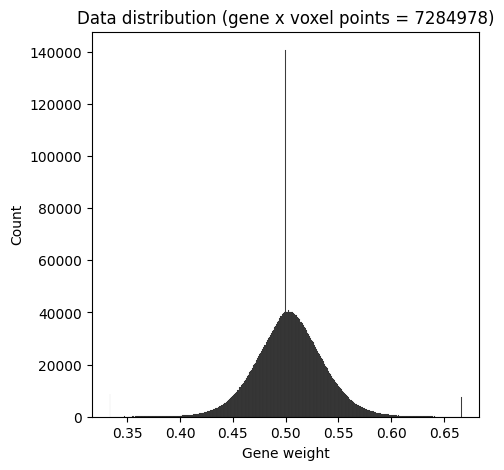

In [9]:
plt.figure(figsize=(5,5))
sns.histplot(pd.melt(dense_expression_data.iloc[:,1:])['value'].values,color='black')
points = pd.melt(dense_expression_data.iloc[:,1:])['value'].values.shape[0]
plt.title("Data distribution (gene x voxel points = "+str(points)+")")
plt.xlabel("Gene weight")
xmin, xmax = plt.xlim()

#### 4. Prime the architecture for the autoencoder
n.b. this code can also be used to retrain the model

In [10]:
print("Priming Autoencoder")

class MLP(nn.Module):
    """A n-layer multi-layer perceptron

    An implementation of a n-layer MLP with
    ELU activation and batch normalization
    """

    def __init__(self, layer_sizes):
        super().__init__()
        self.layer_sizes = layer_sizes
        self.mlp = self._create_model(self.layer_sizes)

    def _create_model(self, layer_sizes):
        layer_list = []
        previous_size = layer_sizes[0]
        j = 0
        for i, size in enumerate(layer_sizes[1:-1]):
            layer_list.append((f"fc{i}", nn.Linear(previous_size, size)))
            layer_list.append((f"bn{i}", nn.BatchNorm1d(size)))
            layer_list.append((f"elu{i}", nn.ELU()))
            previous_size = size
            j = i
        layer_list.append((f"fc{j+1}", nn.Linear(previous_size, layer_sizes[-1])))
        layers = OrderedDict(layer_list)
        return nn.Sequential(layers)

    def forward(self, x):
        return self.mlp(x)
    
class AE(nn.Module):
    """Deep Autoencoder

    Arbitrary-depth autoencoder
    with batch normalization and ELU
    activation on the hidden layers
    """

    def __init__(self, layer_sizes, sigmoid_output=False):
        super().__init__()
        self.layer_sizes = layer_sizes
        self.sigmoid_output = sigmoid_output
        self.encoder = MLP(self.layer_sizes)
        self.decoder = MLP(list(reversed(self.layer_sizes)))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return torch.sigmoid(self.decode(z)) if self.sigmoid_output else self.decode(z)
    
def sum_non_bias_l2_norms(parameters, multiplier=1e-4):
    """
    Given parameters=model.parameters() where model is a PyTorch model, this iterates through the list and tallies
    the L2 norms of all the non-bias tensors.
    """
    l2_reg = 0
    for param in parameters:
        current_shape = list(param.size())
        if len(current_shape) > 1:
            l2_reg += multiplier * torch.mean(torch.square(param))
    return l2_reg

# Function to count the params in a model
def count_unique_parameters(parameters):
    # Only counts unique params
    count = 0
    list_of_names = []
    for p in parameters:
        name = p[0]
        param = p[1]
        if name not in list_of_names:
            list_of_names.append(name)
            count += np.prod(param.size())
    return count


def train_ae(autoencoder, data, epochs=50000,patience=300,kfolds=5,batch_size=128,num_workers=8,oos_mode=True):
    
    kf = KFold(n_splits=kfolds,shuffle=True,random_state=32)
    input_x = data
    input_y = np.random.rand(data.shape[0])
    
    opt = torch.optim.Adam(autoencoder.parameters(),lr = 1e-3)
    batch_size=batch_size
    num_workers=num_workers
    scaler = torch.cuda.amp.GradScaler()
    
    epoch=0
    best_loss = np.inf
    patience_iterator=0
    
    train_loss_list=[]
    val_loss_list=[]
    
    """Epoch iterator"""
    for epoch in tqdm(range(epochs)):
        training_loss_over_whole_epoch = 0
        val_loss_over_whole_epoch = 0
        train_fold_len=0
        val_fold_len=0
        opt.zero_grad()
        
        """Fold iterator"""
        for i, (train_index, val_index) in enumerate(kf.split(input_x)):
            "Data generators"
            train_files = [{"genetic_data":x,'random_y': y} for x, y in zip(input_x[train_index],input_y[train_index])]
            dataset_train = Dataset(data=train_files, transform=None)
            loader_train = DataLoader(dataset_train, shuffle=True, batch_size=batch_size, drop_last=True,
                        num_workers=num_workers,pin_memory=False)
            
            val_files = [{"genetic_data":x,'random_y': y} for x, y in zip(input_x[val_index],input_y[val_index])]
            dataset_val = Dataset(data=val_files, transform=None)
            loader_val = DataLoader(dataset_val, shuffle=False, batch_size=batch_size, drop_last=False,
                        num_workers=num_workers,pin_memory=False)
            
            "Train loop"
            autoencoder.train()
            mode_label='Training fold '+str(i)
            progress_bar = tqdm(loader_train, mode_label + ") Epoch " + str(epoch),leave=False)
            for batch in progress_bar:
                progress_bar_dict = {}
                opt.zero_grad()
                x = batch['genetic_data'].to(torch.float32)
                x = x.to(device, non_blocking=True)
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum()
                loss += sum_non_bias_l2_norms(params)
                
                training_loss_over_whole_epoch += loss.cpu().detach().numpy()
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()

                progress_bar_dict['Loss'] = loss.cpu().detach().numpy()
                progress_bar.set_postfix(progress_bar_dict)
            gc.collect()
                
            "Val loop"
            autoencoder.eval()
            mode_label='Validation fold '+str(i)
            progress_bar = tqdm(loader_val, mode_label + ") Epoch " + str(epoch),leave=False)
            with torch.no_grad():
                for batch in progress_bar:
                    progress_bar_dict = {}
                    x = batch['genetic_data'].to(torch.float32)
                    x = x.to(device, non_blocking=True)
                    x_hat = autoencoder(x)
                    loss = ((x - x_hat)**2).sum()
                    loss += sum_non_bias_l2_norms(params)
                    
                    val_loss_over_whole_epoch += loss.cpu().detach().numpy()
                    
                    progress_bar_dict['Loss'] = loss.cpu().detach().numpy()
                    progress_bar.set_postfix(progress_bar_dict)

            "On fold end"
            train_fold_len+=len(dataset_train)
            val_fold_len+=len(dataset_val)
            gc.collect()
                
        """On epoch end"""
        training_loss_over_whole_epoch /= train_fold_len
        val_loss_over_whole_epoch /= val_fold_len
        

        train_loss_list.append(training_loss_over_whole_epoch)
        val_loss_list.append(val_loss_over_whole_epoch)
        
        if epoch % 100 == 0:
            print("Epoch: "+str(epoch))
            print("Train loss: "+str(training_loss_over_whole_epoch))
            print("Val loss: "+str(val_loss_over_whole_epoch))

        if val_loss_over_whole_epoch<best_loss:
            best_loss = val_loss_over_whole_epoch
            patience_iterator=0
            if oos_mode:
                torch.save(autoencoder.state_dict(),out+'autoencoder_'+str(components)+'components_mm_oos_mode.pt')
            else:
                torch.save(autoencoder.state_dict(),out+'autoencoder_'+str(components)+'components_mm.pt')
            best_epoch=epoch

        else:
            patience_iterator+=1

        if patience_iterator==patience:
            print("Patience criterion reached")
            print("Epoch loss: " + str(val_loss_over_whole_epoch))
            break
            
        gc.collect()
            
    return autoencoder, epoch,train_loss_list,val_loss_list,best_epoch

Priming Autoencoder


In [11]:
latent_dims = components

layer_sizes=[dense_expression_data.shape[1]-1,
             500,
             250,
             125,
             latent_dims]

print("AE layer sizes")
print(layer_sizes)

AE layer sizes
[15633, 500, 250, 125, 64]


In [12]:
autoencoder = AE(layer_sizes,sigmoid_output=True).to(device)

params = []
params += list(autoencoder.parameters())
print("Number of parameters in the AE: " + str(count_unique_parameters(autoencoder.named_parameters())))

Number of parameters in the AE: 15982447


#### 5. Compress the data from step 4 with the autoencoder into the pre-determined number of components

In [13]:
# reload the best performing weights
print("loading model weights from best epoch: ")
autoencoder.load_state_dict(torch.load(path+'autoencode_abagen_'+str(components)+'_components.pt',map_location=torch.device(device)))

test_files = [{"genetic_data":x,'random_y': y} for x, y in zip(dense_expression_data.iloc[:,1:].values,y)]
dataset_test = Dataset(data=test_files, transform=None)

loader_test = DataLoader(dataset_test, shuffle=False, batch_size=batch_size, drop_last=False,
                        num_workers=num_workers,pin_memory=False)

zs = np.empty(shape=(0,components))
ae_recon = np.empty(shape=(0,dense_expression_data.iloc[:,1:].shape[1]))
test_loss_over_whole_epoch=0

for batch in loader_test:
    x = batch['genetic_data'].to(torch.float32)
    x = x.to(device, non_blocking=True)
    z = autoencoder.encoder(x.to(device))
    z = z.to('cpu').detach().numpy()
    zs = np.concatenate((zs,z), axis=0)
    d = autoencoder(x.to(device))
    d = d.to('cpu').detach().numpy()
    ae_recon = np.concatenate((ae_recon,d), axis=0)
    x_hat = autoencoder(x)
    loss = ((x - x_hat)**2).sum()
    test_loss_over_whole_epoch += loss.cpu().detach().numpy()
    
mse = ((dense_expression_data.iloc[:,1:].values.flatten() - ae_recon.flatten())**2).mean()
rmse = np.sqrt(mse)

loading model weights from best epoch: 


#### 6. View some example dimensions of the latent space

Text(0.5, 1.0, 'Autoencoder | 64 Components | Sample dataset')

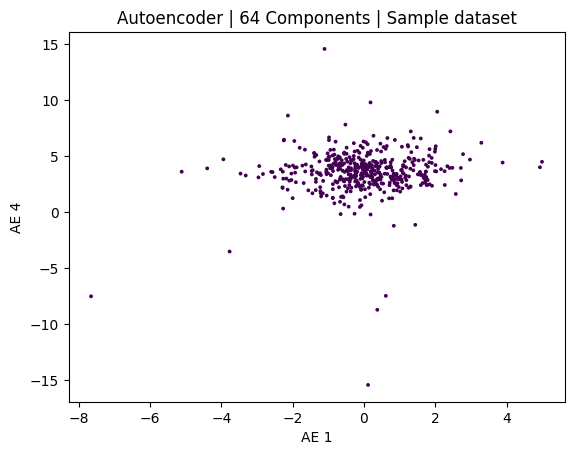

In [14]:
latent_i=1
latent_j=4
fig, ax = plt.subplots()
plt.scatter(zs[:, latent_i], zs[:, latent_j],s=3,c=y)
plt.xlabel("AE "+str(latent_i))
plt.ylabel("AE "+str(latent_j))
plt.title('Autoencoder | '+str(components)+' Components | Sample dataset')

#### 7. Compare the compression of your own data to the reconstruction
This step quantifies the ability of the autoencoder latents to reconstruct the source data, i.e. is a marker of the variance it captures

Text(0.5, 1.0, 'Autoencoder recon on test set: RMSE 0.0241381 | 64 Components')

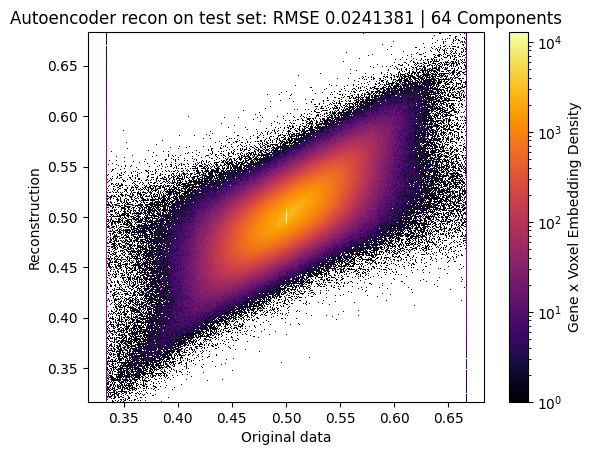

In [15]:
fig, ax = plt.subplots()
using_datashader(ax, dense_expression_data.iloc[:,1:].values.flatten(), ae_recon.flatten())
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel("Original data")
plt.ylabel("Reconstruction")
plt.title("Autoencoder recon on test set"+": RMSE "+str(np.round(rmse,8))+' | '+str(components)+' Components')